# **Sensors and Sensing Course**
## Home Assignment 3

Nabila Adawy


B19-RO-01


n.roshdy@innopolis.university

### **To run the code:**


Upload this file to colab notebook and "left.png","right.png","gps.csv","acc.csv" files to test the code.

### **References**

[ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) 

[pixel_coordinates](https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python)

[Fundmental_Matrix](https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py)

[Disparity_Map](https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)

### **Importing all the libraries we need.**

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import utm

# Task 1

Our goal in this task is to use 8 point algorithm in order to find the fundamental matrix.

### **Keypoints Detection**

First, I uploaded the left and right images that correspond to my id [01], Then used ORB from openCV for Keypoints detection.

In [2]:
# Loading left and right images in a grayscale mode
img1 = cv.imread('left.png',0)
img2 = cv.imread('right.png',0)

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints with ORB
kp1 = orb.detect(img1,None)
kp2 = orb.detect(img2,None)

# compute the descriptors with ORB
kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)

After that, we can draw keypoints locations on the images

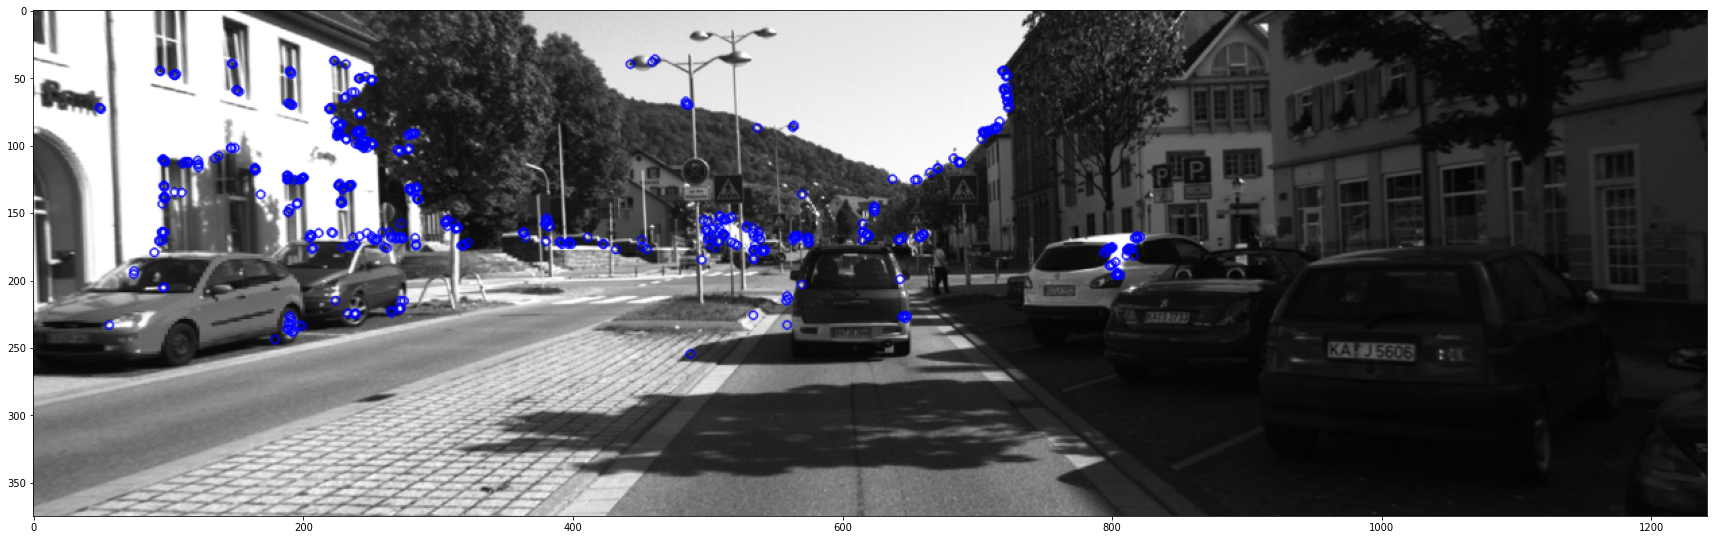

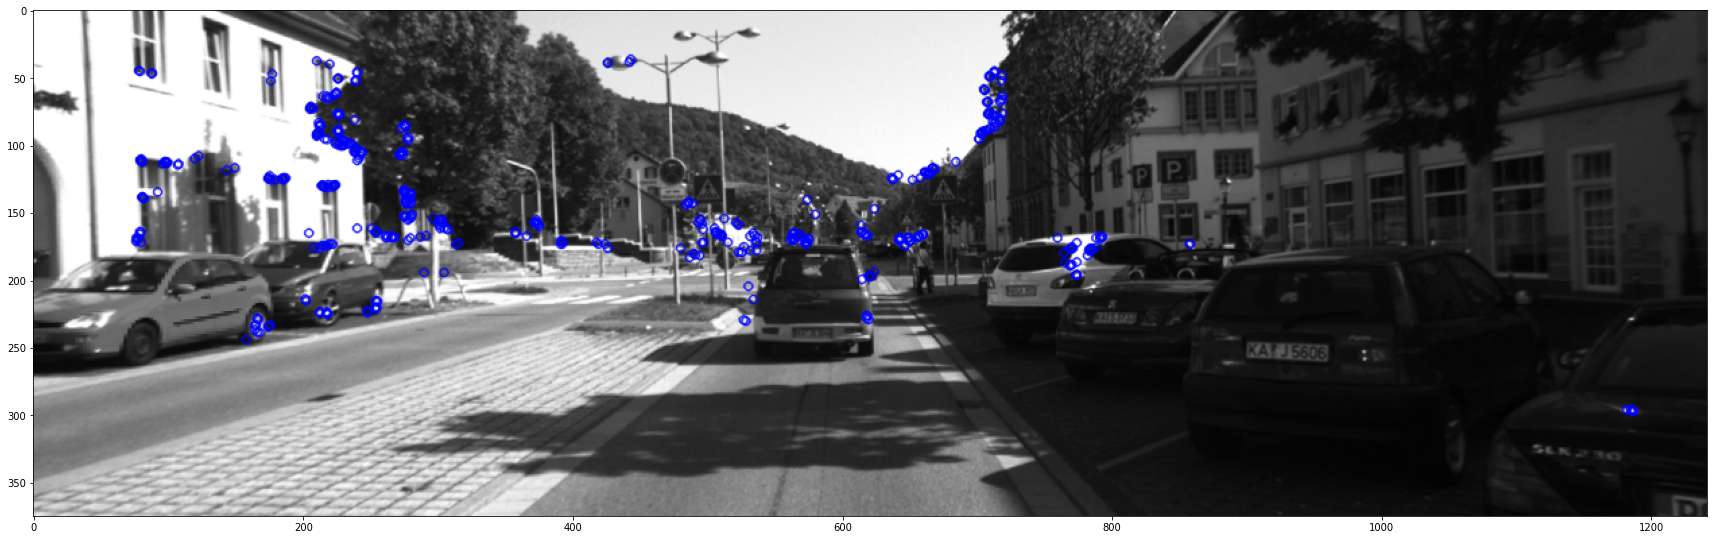

In [3]:
# draw only keypoints location, not size and orientation
img3 = cv.drawKeypoints(img1, kp1, None, color=(0,0,255), flags=0)
img4 = cv.drawKeypoints(img2, kp2, None, color=(0,0,255), flags=0)

plt.figure(figsize=(30,30))
plt.imshow(img3)
plt.show()
plt.figure(figsize=(30,30))
plt.imshow(img4)
plt.show()

### **Matching Keypoints**

Second, we need to Match the keypoints and Draw first 30 points

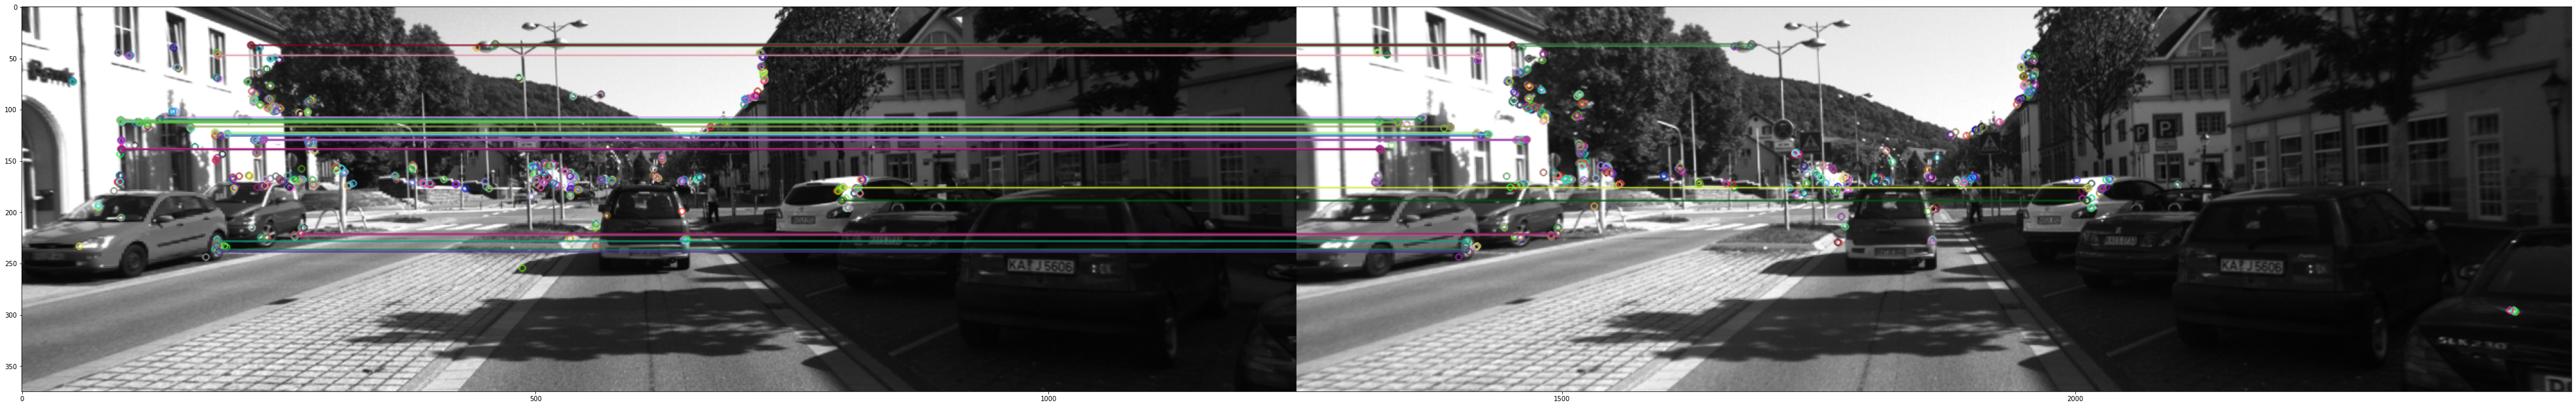

In [4]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 30 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:30], None)
plt.figure(figsize=(70,50))
plt.imshow(img3)
plt.show()

Third, we need to get the lists of the x and y coordinates of the keypoints that the feature matcher selected

In [5]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

X1 = np.array(list_kp1)
X2 = np.array(list_kp2)

### **Computing the Fundmental Matrix**

We need to compute the fundmental matrix from corresponding points.
Each row in the A matrix below is constructed as
[x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] and following the steps mentioned in lab05 we can obtain the fundmental matrix.

In [6]:
def compute_fundamental(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]

F = compute_fundamental(X1,X2)
print(F)    

[[-0.66200279  0.65988468 -0.39381064]
 [-0.0697245   0.13753253 -0.36170365]
 [-0.22101736 -0.02006909  1.        ]]


### **Disparity Map Estimation**

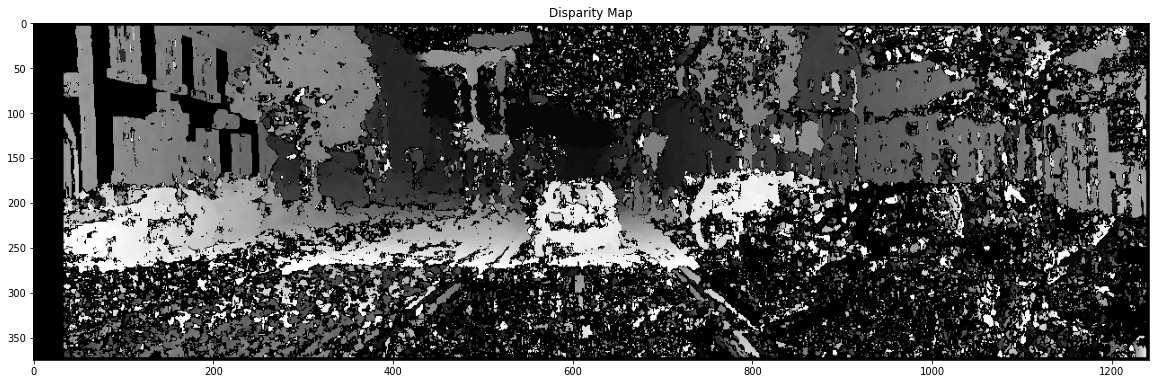

In [7]:
stereo = cv.StereoBM_create(32, 7)
disparity = stereo.compute(img1, img2)

plt.figure(figsize=(20,20))
plt.imshow(disparity, 'gray')
plt.title('Disparity Map')
plt.show()

# Task 2

Our goal in this task is to estimate the trajectory of running for 100 m with a constant speed. Record the data using phone sensers, and implement Multidimensional Kalman filter with sensor
fusion in order to solve this task.

In [8]:
!pip install utm

I used "Physics Toolbox Suit app" and recorded data from GPS sensor and accelometer. Then I followed lab06 and designed my multidimentional kalman filter based on the equations in that labsheet.


#### **Reading the data from both sensors: GPS and Accelerometer**

In [9]:
acc_data = pd.read_csv('acc.csv')
gps_data = pd.read_csv('gps.csv')

lat = gps_data['Latitude'].values
lon = gps_data['Longitude'].values

#### **Convert GPS measurements into world coordinates**

In [10]:
gps_x, gps_y, lon_zone, lat_zone = utm.from_latlon(lat, lon)
ddx = acc_data['ax'].values
ddy = acc_data['ay'].values
gps_time = gps_data['time'].values
acc_time = acc_data['time'].values

In [11]:
def plot_xy(x,y, xlabel, ylabel, legend):
    fig = plt.figure(figsize=(5,5))
    
    plt.scatter(x,y, s=3, label='STATE', c='black')
    plt.scatter(x[0],y[0], s=50, label='START', c='brown')
    plt.scatter(x[-1],y[-1], s=50, label='END', c='orange')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(legend)
    plt.legend(loc='best')
    plt.axis()

#### **Plotting GPS data**

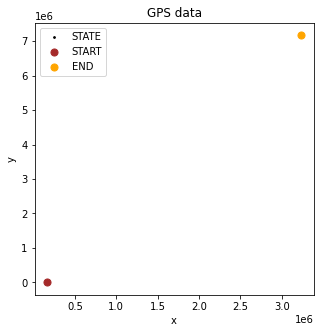

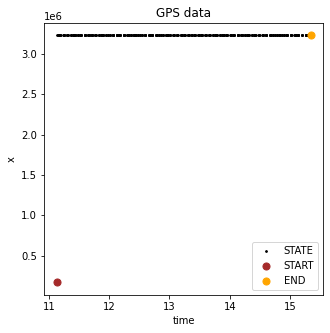

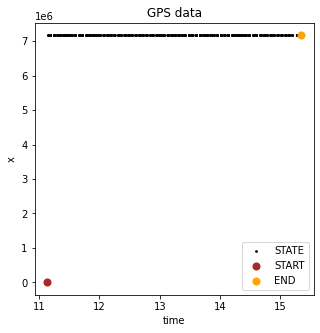

In [12]:
plot_xy(gps_x, gps_y, 'x', 'y', 'GPS data')
plot_xy(gps_time, gps_x, 'time', 'x', 'GPS data')
plot_xy(gps_time, gps_y, 'time', 'x', 'GPS data')

#### **Plotting Accelometer data**

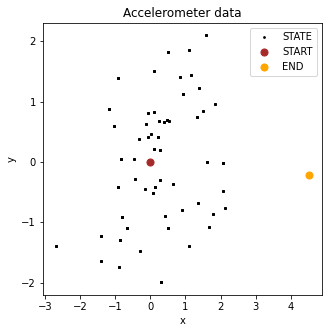

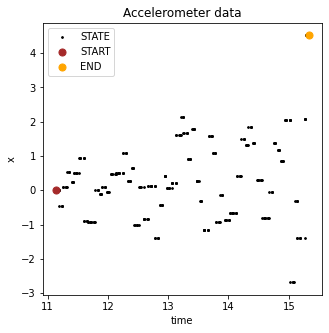

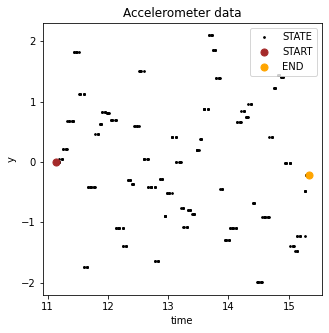

In [13]:
plot_xy(ddx, ddy, 'x', 'y', 'Accelerometer data')
plot_xy(acc_time, ddx, 'time', 'x', 'Accelerometer data')
plot_xy(acc_time, ddy, 'time', 'y', 'Accelerometer data')

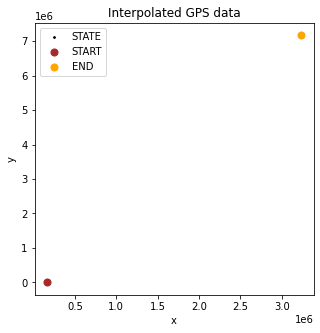

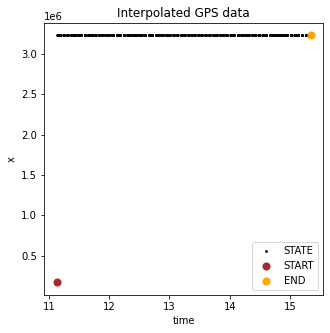

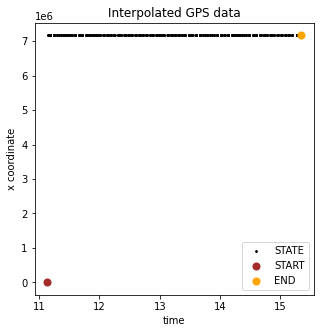

In [14]:
time = acc_time
# we have data from sensors with different shapes. 
#so, we need to interpolate the GPS data in order to get the same shape as accelerometer data
x = np.interp(time, gps_time, gps_x)
y = np.interp(time, gps_time, gps_y)

plot_xy(x, y, 'x', 'y', 'Interpolated GPS data')

plot_xy(time, x, 'time', 'x', 'Interpolated GPS data')

plot_xy(time, y, 'time', 'x coordinate', 'Interpolated GPS data')

**We can notice that we have no difference between GPS data graph and Interpolated GPS data graph, because I have the same timestamp in both sensors**

In [15]:
# computing means and stds of our measurements
std_x = x.std()
mean_x = x.mean()
std_y = y.std()
mean_y = y.mean()
std_ddx = ddx.std()
mean_ddx = ddx.mean()
std_ddy = ddy.std()
mean_ddy = ddy.mean()

# Error in gps
std_x = 20
std_y = 10

# # Error in accelerator
std_ddx = 4
std_ddy = 3

### **Defining Main Matrices**

In [16]:
# measurement noise covariance matrix R
def matrix_R(std_x, std_y):
    R = np.array([[std_x**2, 0],
                  [0, std_y**2]], dtype=float)
    R = R.reshape(2, 2)
    return R

# process noise co-variance matrix Q 
def matrix_Q(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    Q = np.array([[sigma_x**2, 0, sigma_x*sigma_dx, 0],
                  [0, sigma_y**2, 0, sigma_y*sigma_dy],
                  [sigma_x*sigma_dx, 0, sigma_dx**2, 0],
                  [0, sigma_y*sigma_dy, 0, sigma_dy**2]], dtype=float)
    Q = Q.reshape(4, 4)
    return Q

# state vector X [x, y, dx, dy]
def vector_X(x, y, dx, dy):
    X = np.array([[x],
                  [y],
                  [dx],
                  [dy]], dtype=float)
    X = X.reshape(4, 1)
    return X

# dynamics matrix A
def matrix_A(dt):
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    A = A.reshape(4, 4)
    return A

# control Matrix
def matrix_B(dt):
    B = np.array([[(dt**2)/2, 0],
                  [0, (dt**2)/2],
                  [dt, 0],
                  [0, dt]], dtype=float)
    B = B.reshape(4, 2)
    return B

# control Input u
def vector_u(ddx, ddy, dt):
    u = np.array([[ddx],
                  [ddy]], dtype=float)
    u = u.reshape(2, 1)
    return u

# observation Matrix
def matrix_C():
    C = np.array([[1, 0],
                  [0, 1]], dtype=float)
    C = C.reshape(2, 2)
    return C

# Measuring Matrix
def matrix_H():
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]], dtype=float)
    H = H.reshape(2, 4)
    return H

# Matrix of measurements' noise
def vector_Z(std_x, std_y):
    Z = np.array([[np.random.normal(loc = 0, scale = std_x)],
                  [np.random.normal(loc = 0, scale = std_y)]], dtype=float)
    Z = Z.reshape(2, 1)
    return Z

# Matrix of process' noise
def vector_W(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    W = np.array([[np.random.normal(loc = 0, scale = sigma_x)],
                  [np.random.normal(loc = 0, scale = sigma_y)],
                  [np.random.normal(loc = 0, scale = sigma_dx)],
                  [np.random.normal(loc = 0, scale = sigma_dy)]], dtype=float)
    W = W.reshape(4, 1)
    return W

# Co-variance matrix P
def vector_P():
    P = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    P = P.reshape(4, 4)
    return P
n = time.shape[0] - 1
u = np.zeros((2,n), dtype=float)

### **Multidimensional Kalman Filter Algorithm**

In [17]:
time = time/1000
dt = []

for i in range(n):
    dt.append(time[i+1] - time[i])
    u_i = vector_u(ddx[i], ddy[i], dt[i])
    u[:, i] = u_i[:, 0]
    
dt = np.array(dt)

Ym = np.array([x[0:-1], y[0:-1]])

C = matrix_C()
R = matrix_R(std_x, std_y)
H = matrix_H()

X_0 = vector_X(x[0], y[0], 0, 0)
X = np.zeros((4,n), dtype=float)
X[:, 0] = X_0[:, 0]

def Kalman_algorithm():
    Kalman_list = []
    P = vector_P()
    for i in range(n-1):
        A = matrix_A(dt[i])
        B = matrix_B(dt[i])
        Q = matrix_Q(std_ddx, std_ddy, dt[i])
        Z = vector_Z(std_x, std_y)
        W = vector_W(std_ddx, std_ddy, dt[i])
        # predection
        # calculating the state pred.
        X_pred = np.matmul(A, X[:, i]) + np.matmul(B, u[:, i]) #+ W[:, 0]
        # calculating the covariance matrix
        P = np.matmul(A, np.matmul(P, A.transpose())) + Q

        # CORRECTION
        # computing Kalman's gain
        K = np.matmul(np.matmul(P, H.transpose()), np.linalg.pinv(np.matmul(H, np.matmul(P, H.transpose())) + R))
        # computing the measurements
        Y = np.matmul(C, Ym[:, i]).reshape(-1,1) #+ Z
        # Update state extimate
        x = X_pred.reshape(-1, 1) + np.matmul(K, Y - np.matmul(H, X_pred).reshape(-1,1))
        X[:, i+1] = x.reshape(-1,)
        # updating the covariance matrix
        P = np.matmul((np.eye(4, k=0) - np.matmul(K, H)), P)
        Kalman_list.append(K)
        Kalman_gains = np.array(Kalman_list)
    return X, Kalman_gains

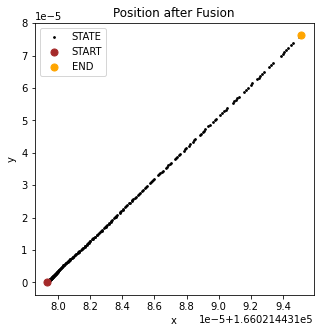

In [18]:
X, Kalman_gains = Kalman_algorithm()
plot_xy(X[0], X[1], 'x', 'y', 'Position after Fusion')

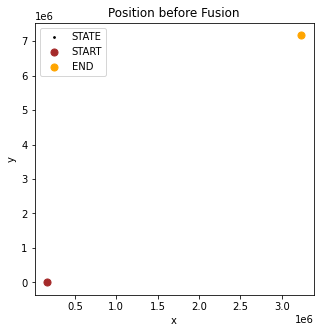

In [19]:
plot_xy(x,y, 'x', 'y', 'Position before Fusion')